#数据集 & 数据集加载器
## 1 数据集加载原语
PyTorch提供了两个数据原语
+ `torch.utils.data.Dataset`:数据集原语，用于存储样例数据以及其对应的标签
+ `torch.utils.data.DataLoader`：数据加载器原语，用于在数据集上增加一个迭代器(iterable),使得访问数据集更加的简介方便。
PyTorch提供了许多的基本数据集，用于预加载和预训练
    + [Image](https://pytorch.org/vision/stable/datasets.html)
    + [Text](https://pytorch.org/text/stable/datasets.html)
    + [Audio](https://pytorch.org/audio/stable/datasets.html)

## 2 加载数据集
以PyTorch提供的数据集为例子，实现一个在线加载数据集的操作。数据集Fashion-MNIST可以通过TorchVision加载，这是一个包含了十个类别的灰度图像。一个数据集的记载，一般包含几个参数。
+ `root`: 数据集的存储路径
+ `train`：为True表示为训练集，为False表示为测试集
+ `download=True`：表示如果本地不存在，则在网络上下载
+ `transform` and `target_transform`：指定标签和特性的转换形式目标，如将数据集转化成tensor数据结构。

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset # 引入数据集原语
from torchvision import datasets  # 从视觉库中引入数据集
from torchvision.transforms import ToTensor # 从视觉库中引入转码器

train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 3 迭代和可视化数据集
可以使用`matplotlib`进行数据集的可视化，可以对刚才的数据及进行简单的切片，或者直接利用下标进行操作，就跟第一节的tensor所具有的操作一样。
在进行获取数据集操作时，会同时获取数据以及其对应的标签。

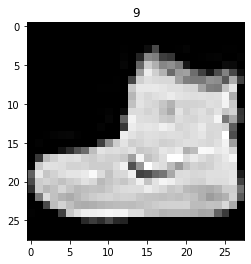

In [5]:
img, label = train_data[0]
plt.title(label)
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

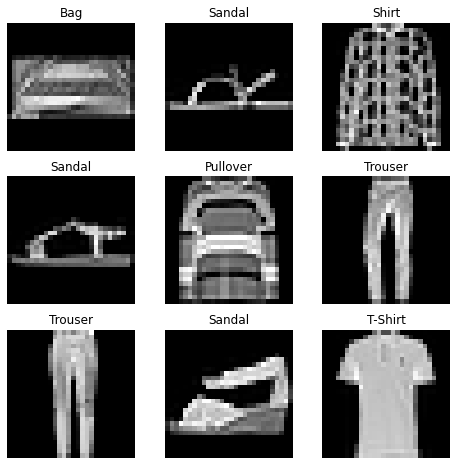

In [7]:
# 官方示例
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 4 创建自定义数据集
可以根据自己的文件创建自定义的数据集，但是需要实现三个方法。
+ `__init__`:创建对象时的初始化函数，参数需要包含标签文件，数据文件，转换器和标签转换器
+ `__len__`: 返回数据集的大小，长度等信息，无参数
+ `__getitem__`：返回给定下标的数据以及其对应的标签，参数就是下标

In [8]:
# 官方样例实现
import os
import pandas as pd
from torchvision.io import read_image # io方法

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        '''
        annotations_file: 标签文件文件名
        img_dir:数据文件文件夹，此处是图像文件
        transform 和 target_transform，数据集和标签转换器
        '''
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        '''
        返回长度
        '''
        return len(self.img_labels)

    def __getitem__(self, idx):
        '''
        返回对应下标的数据和标签
        '''
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## 5 使用数据集加载原语迭代加载数据集
使用`Dataset`方法直接加载数据集，会一次性将数据集加载进来。而实际在模型的训练过程中，我们为了避免模型的过拟合，更加推荐分批次小量的送到模型中进行训练。因此就需要有`DataLoader`这个方法的出现，可以通过`batch_size`来决定每次加载的数量。在实际训练过程中，也会使用`mutilprocessing`来加快训练和读取的速度。
将数据加载进DataLoader之后，便可以直接使用此结构进行迭代获取数据集合。

In [10]:
# 加载
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data, batch_size=64,shuffle=True) # shuffle 表示随即打乱数据集的顺序
test_dataloader = DataLoader(test_data, batch_size=64,shuffle=True)

# 迭代
train_features, train_labels = next(iter(train_dataloader))
print('加载的集合大小', train_features.size())  # 64 张， 通道为1，像素为28*28
print('加载的标签数目', train_labels.size()) 

加载的集合数目 torch.Size([64, 1, 28, 28])
加载的标签数目 torch.Size([64])
